In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import scipy as sp
import math
# import runpy

from sklearn.manifold import MDS

Ts = 1000
data_path = r'C:\Users\IBS\Desktop\python_code_N2'
save_path = r'C:\Users\IBS\Desktop\figures'

In [6]:
import pre_processing

ppss = pre_processing.pre_processing(Ts, data_path, save_path)
[final_cat, data_cat, val_cat, dur_cat, rejectedXY_cat] = ppss.datasorting_orientation(1)

In [7]:
from scipy.ndimage import gaussian_filter1d

Ts = 1000
win = 20 # timewindow (ms), if sampling rate is 1000hz, win=10 is 10ms
# b=[2,3,9,15,14,13,7,1];
# label_ori={'Up','Up right', 'Right', 'Down right',...
#     'Down', 'Down left', 'Left', 'Up left'};

peak_all = []
for data_num in range(np.shape(data_cat)[0]):

    valcat_t = val_cat[data_num]
    datacat_t = data_cat[data_num]

    peak = []
    for a in range(8):

        # Peak
        vv = np.mean(valcat_t[a], axis = 0)
        I = np.where(max(vv) == vv)[0][0]
        s_temp = gaussian_filter1d(np.sum(datacat_t[a], axis = 0), win)
        I2 = np.where(max(s_temp) == s_temp)[0][0]
        peak.append(I2 - I)

    peak_all.append(peak)

onset_delay = np.array(peak_all) / Ts

In [8]:
df(onset_delay)

,0,1,2,3,4,5,6,7
0,0.030,0.030,0.006,0.002,-0.010,0.006,0.022,0.042
1,0.016,0.025,-0.018,-0.018,-0.018,-0.015,0.003,0.021
2,-0.048,-0.025,-0.026,-0.023,-0.008,-0.014,-0.019,-0.025
3,-0.028,-0.007,-0.029,-0.046,-0.026,-0.013,-0.019,-0.034
4,0.202,0.149,-0.017,-0.315,0.078,0.191,-0.004,-0.004
...,...,...,...,...,...,...,...,...
62,-0.278,-0.035,-0.037,-0.029,-0.011,-0.017,-0.001,-0.091
63,-0.316,-0.317,-0.011,-0.023,-0.010,-0.007,-0.317,-0.029
64,-0.019,-0.021,-0.006,0.010,0.023,0.038,0.016,-0.007
65,-0.011,-0.008,-0.022,-0.028,-0.030,-0.014,-0.010,-0.008


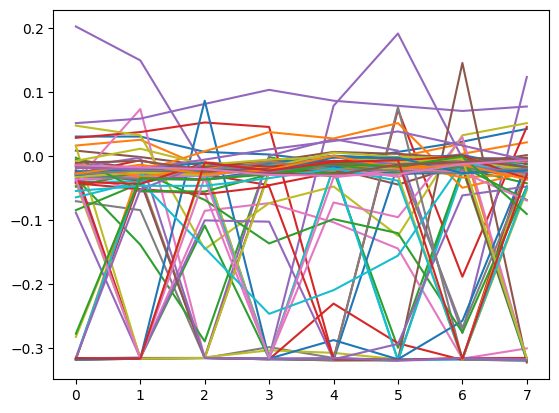

In [9]:
for a in range(len(onset_delay)):
    plt.figure
    plt.plot(onset_delay[a])


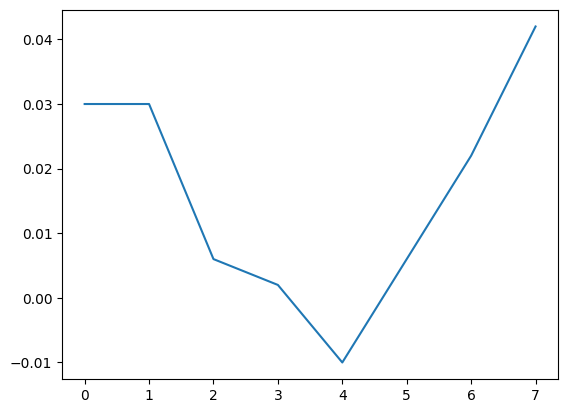

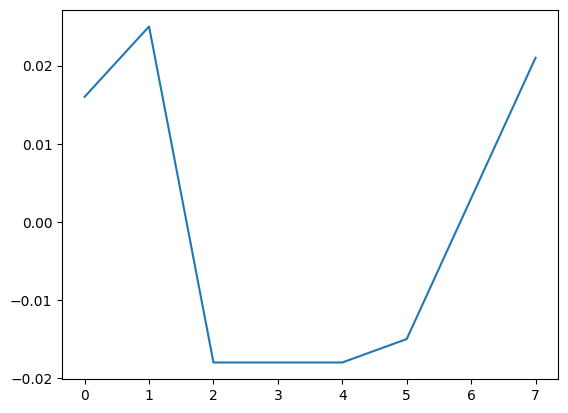

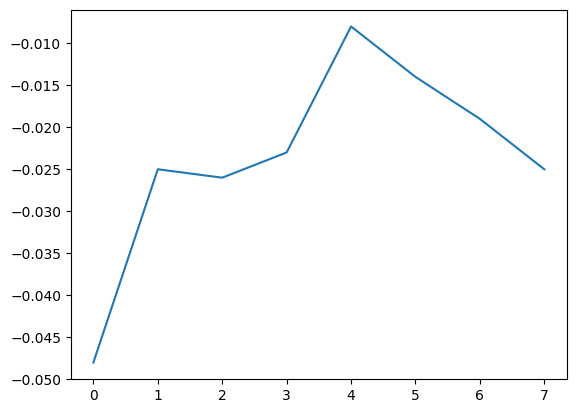

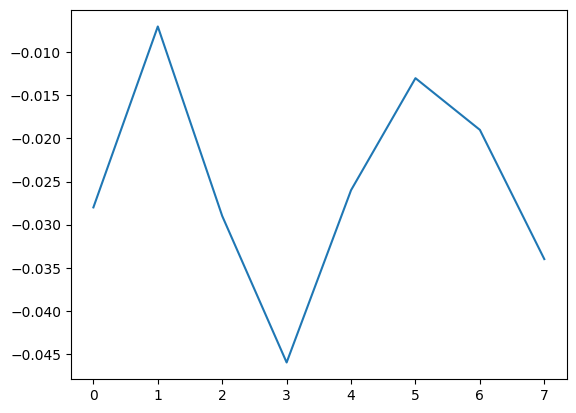

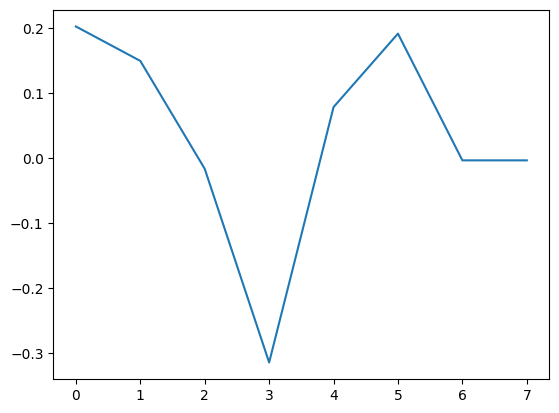

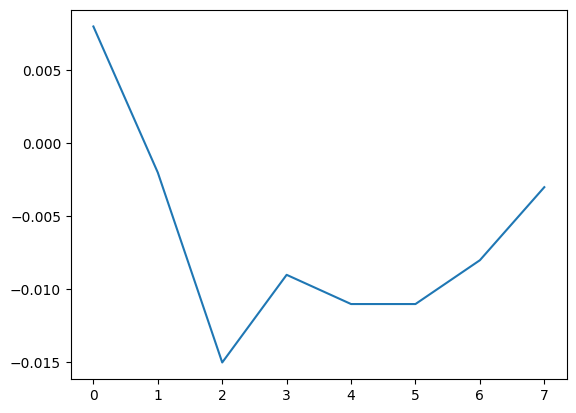

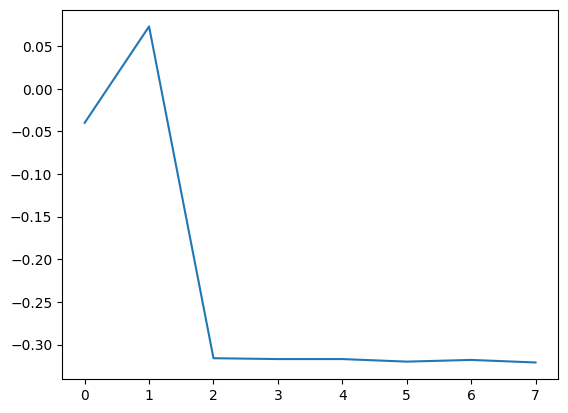

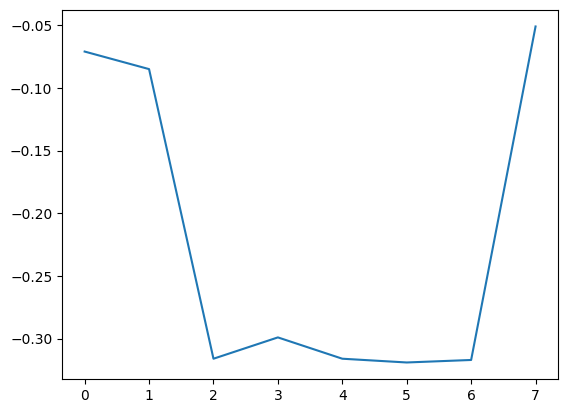

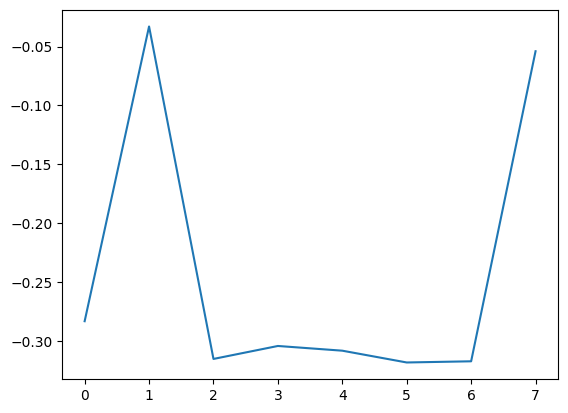

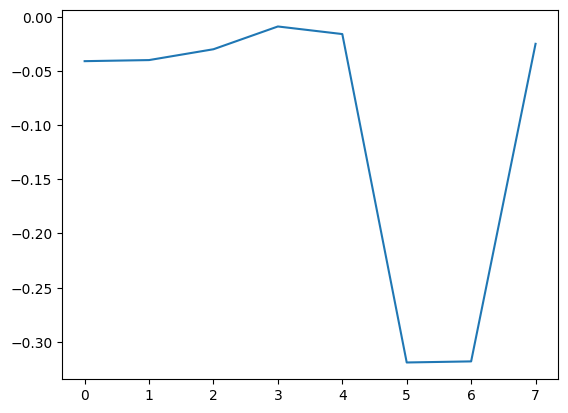

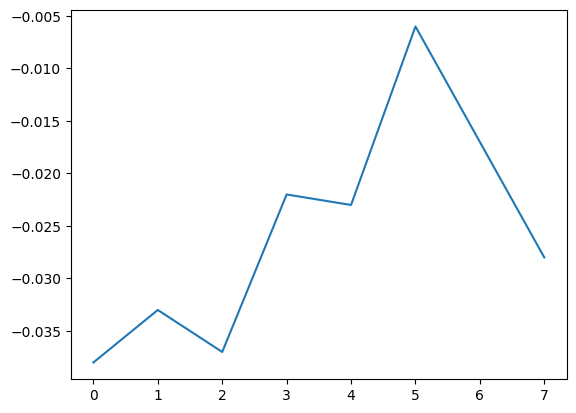

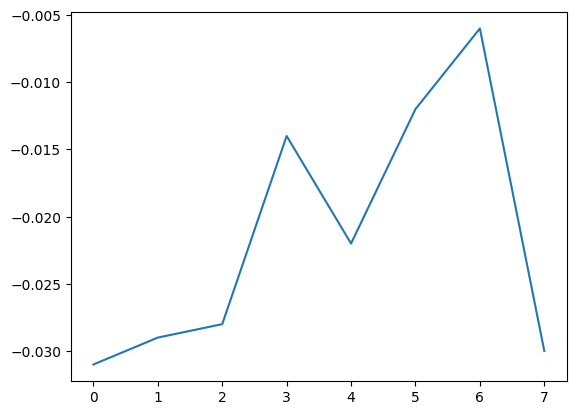

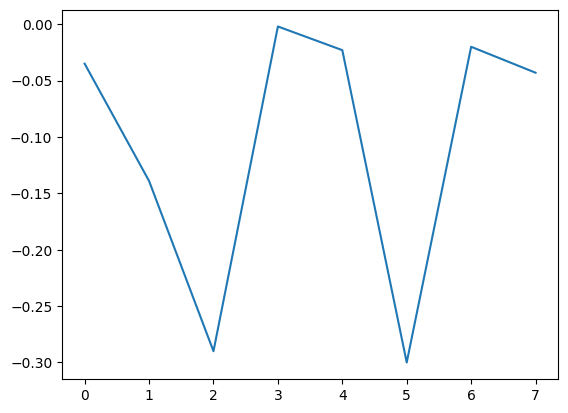

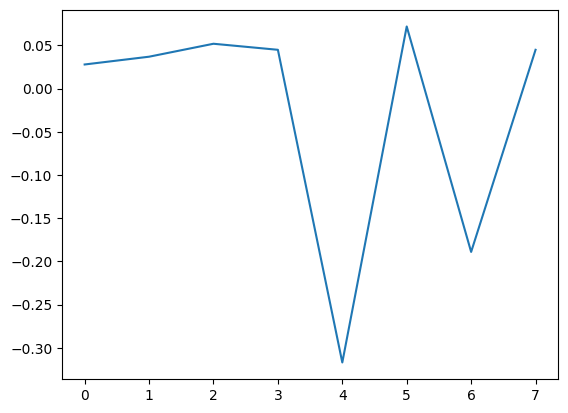

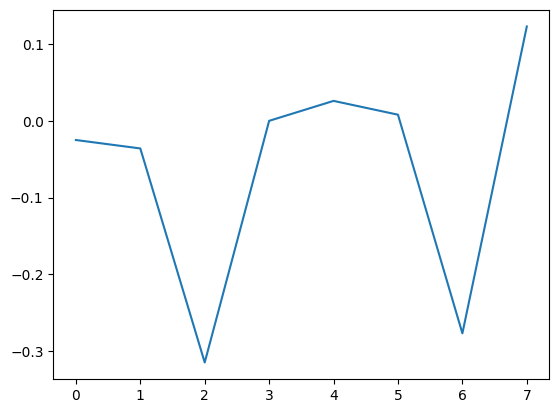

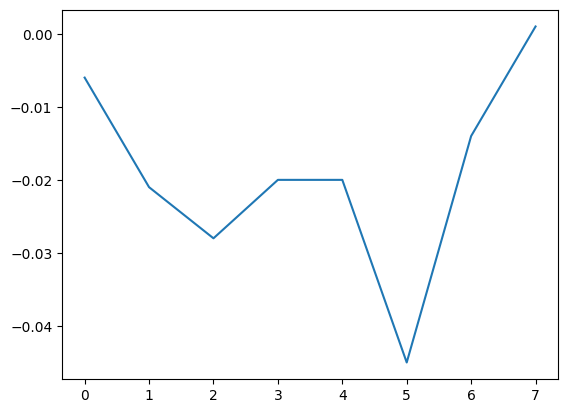

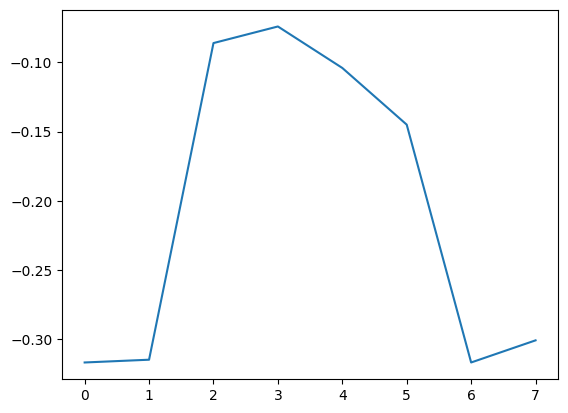

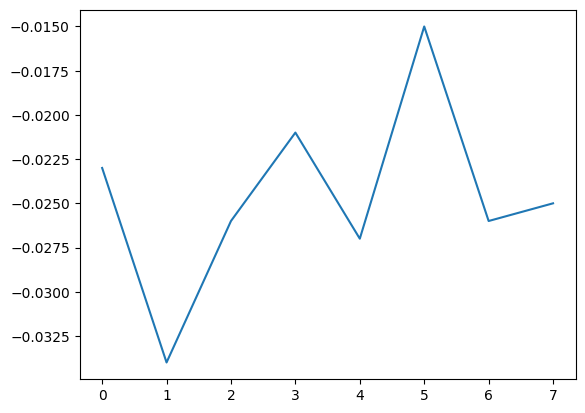

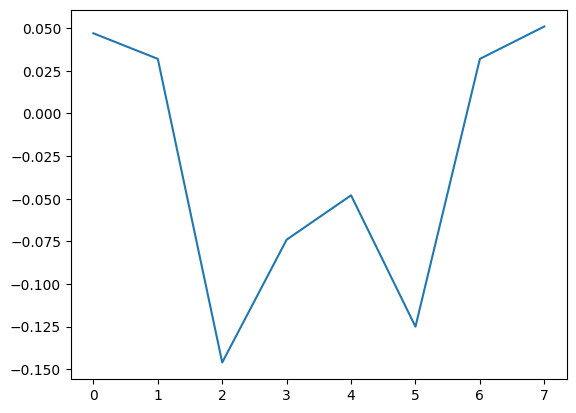

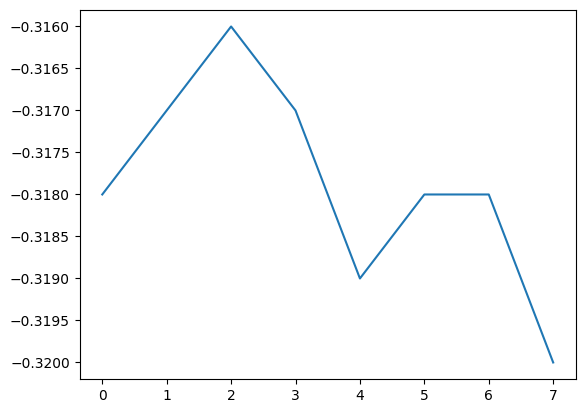

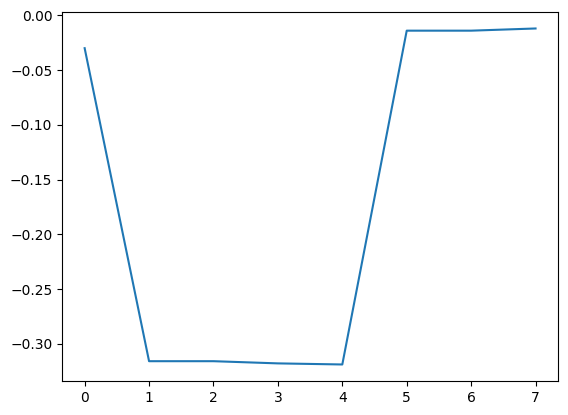

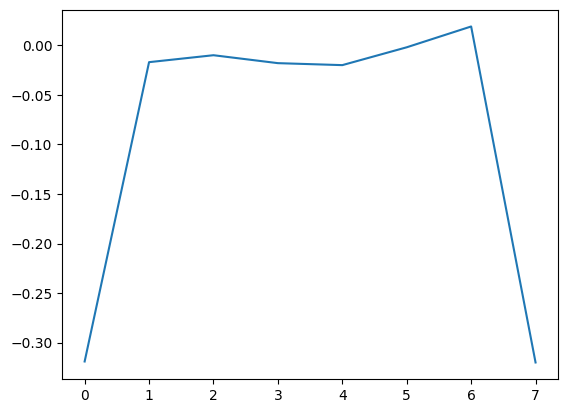

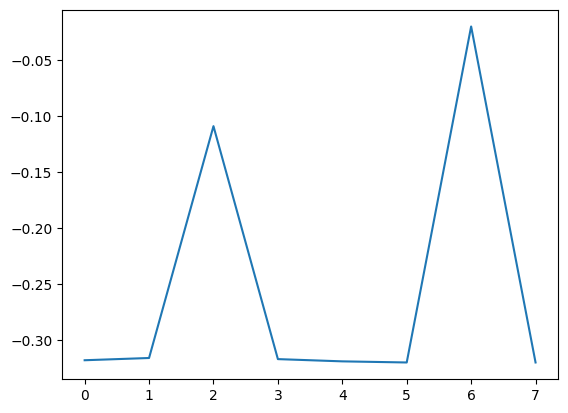

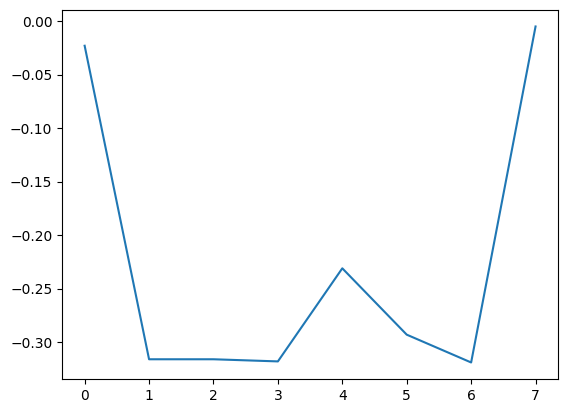

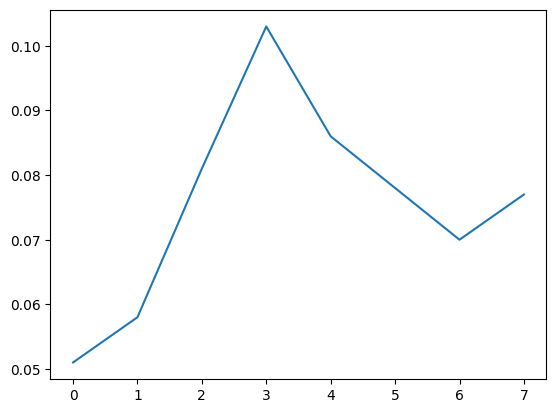

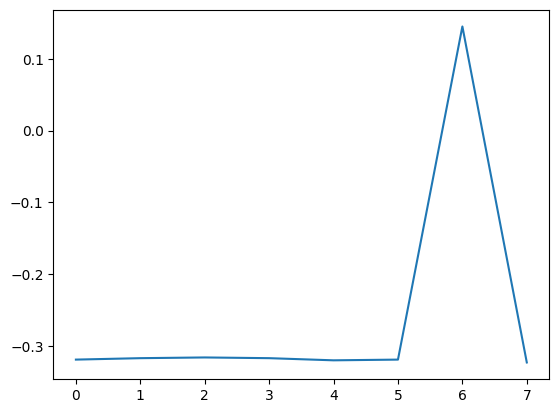

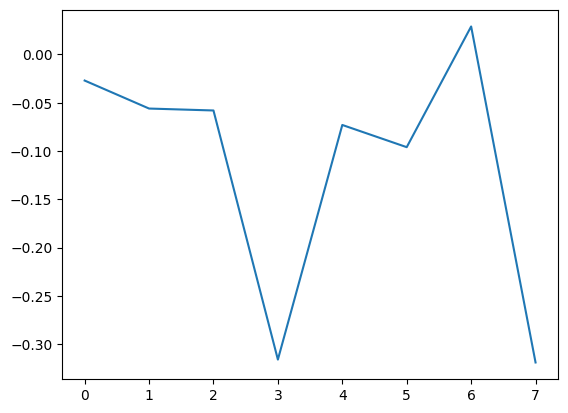

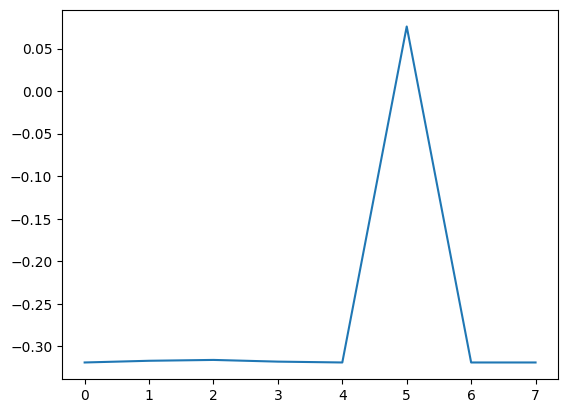

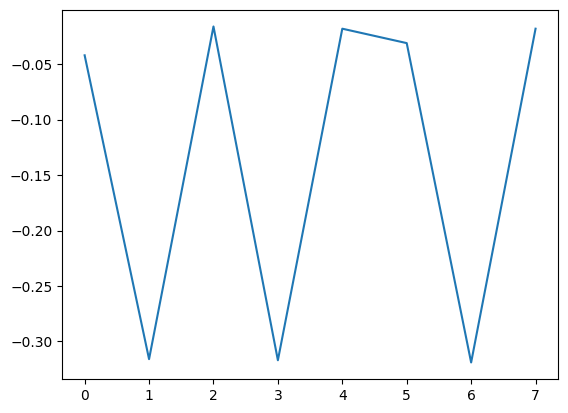

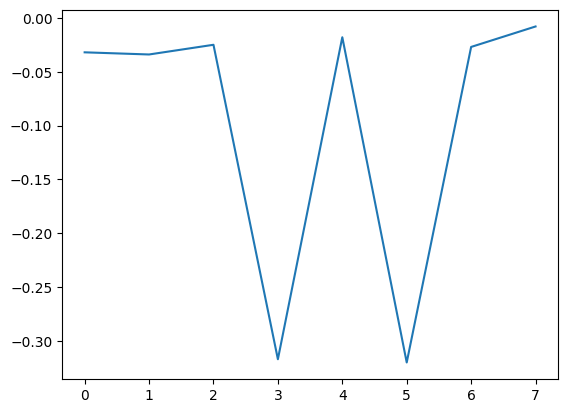

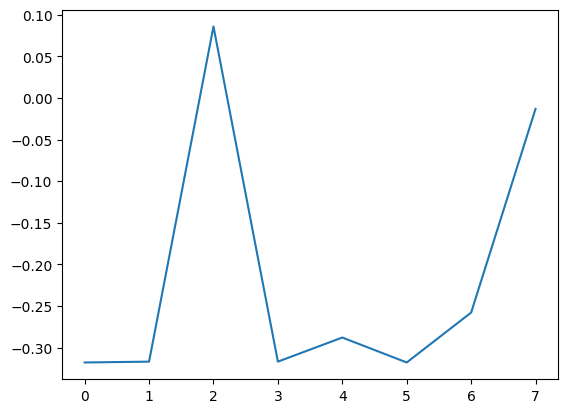

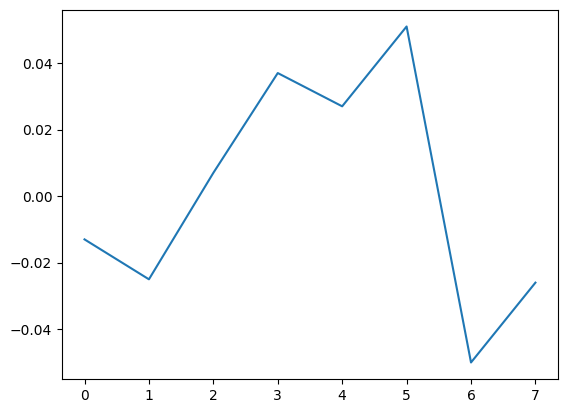

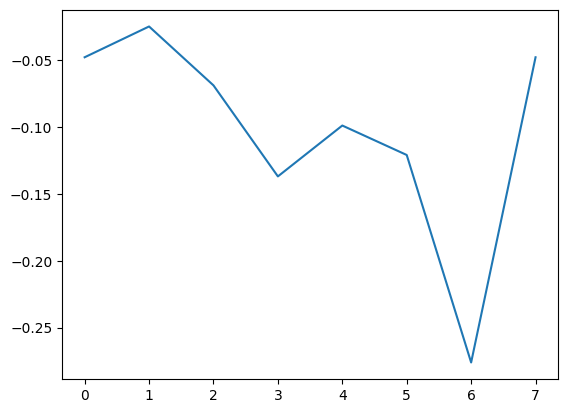

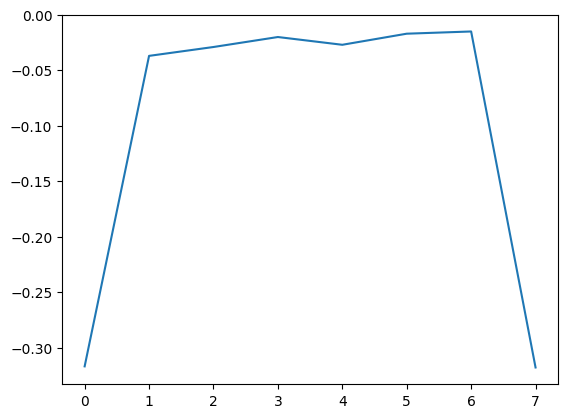

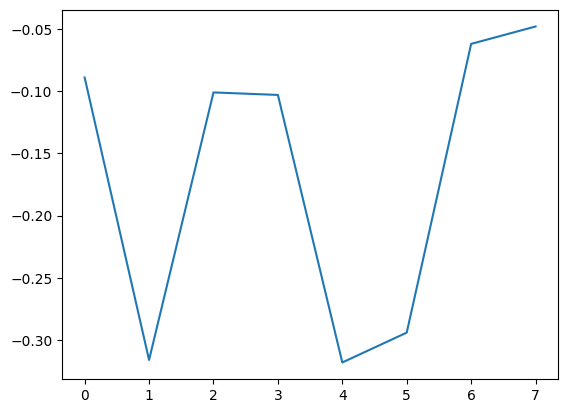

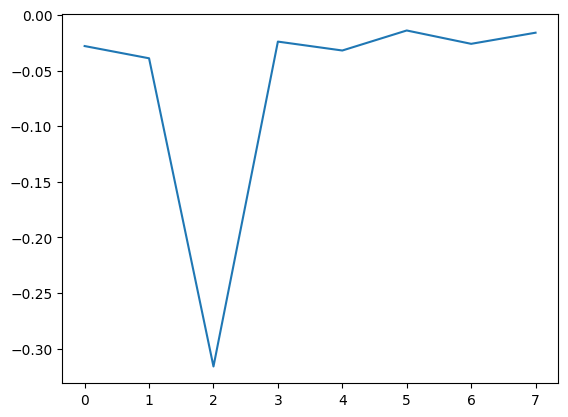

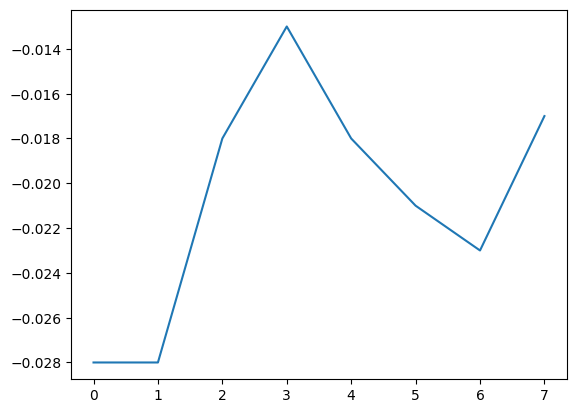

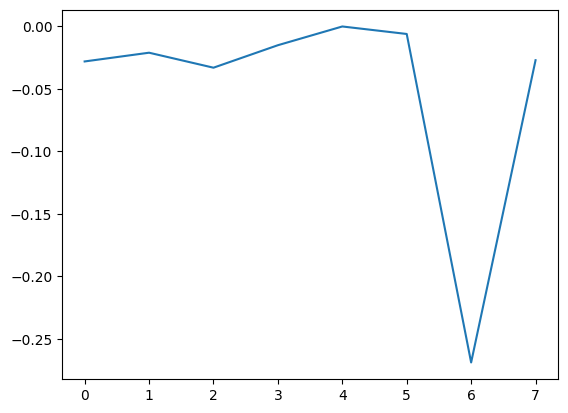

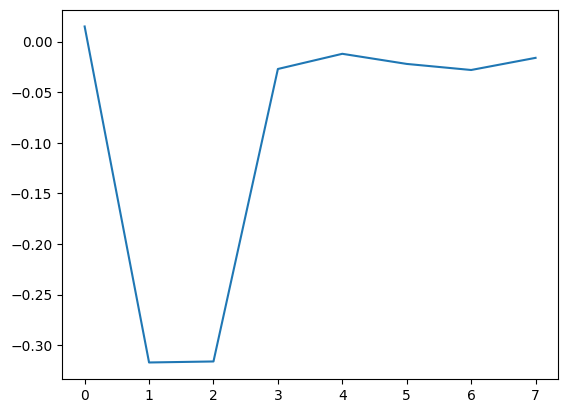

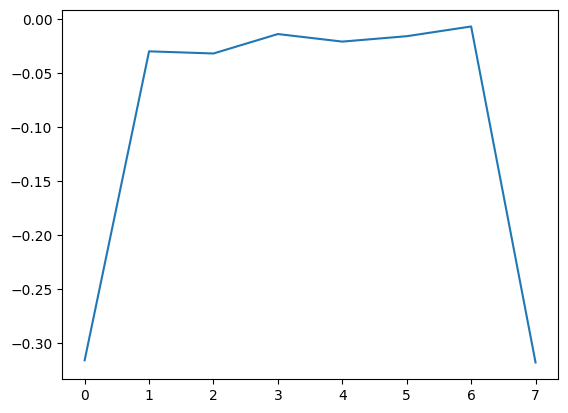

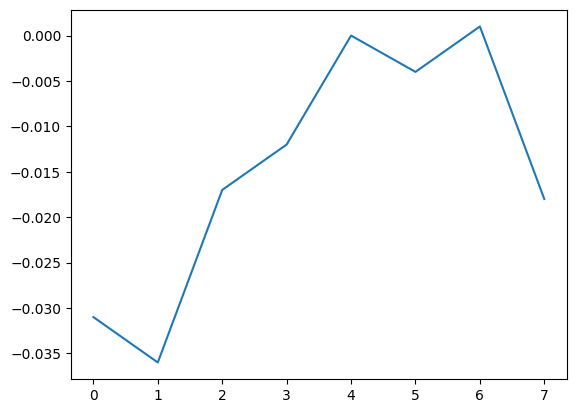

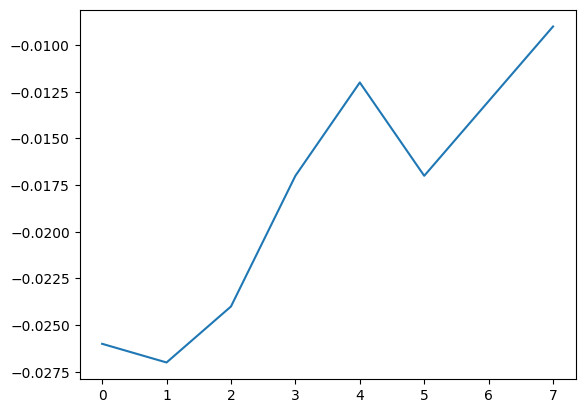

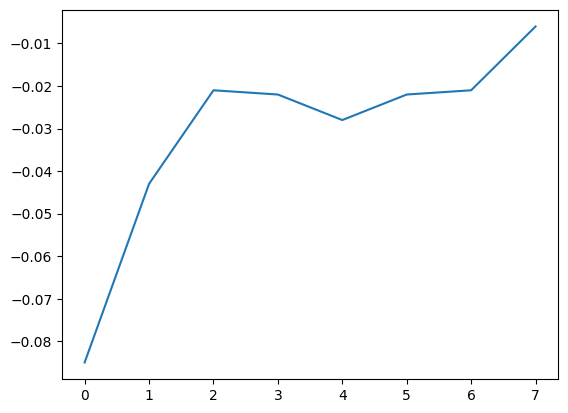

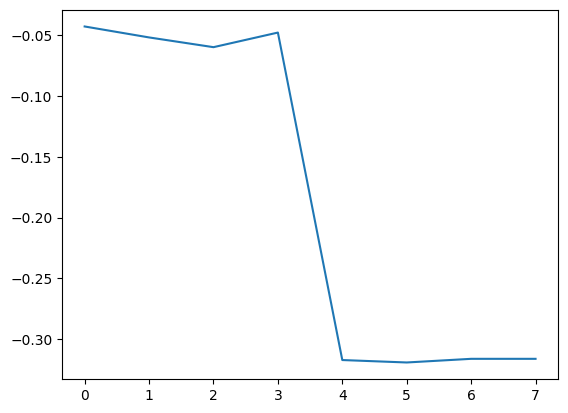

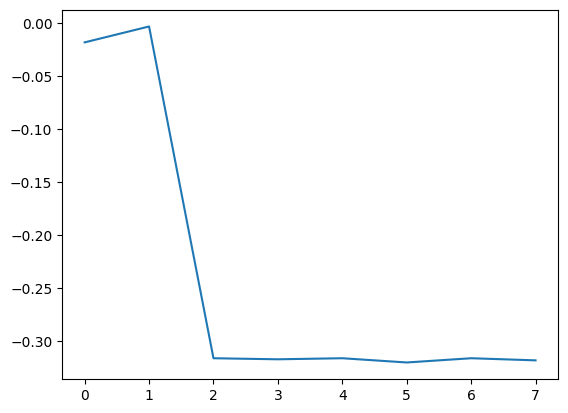

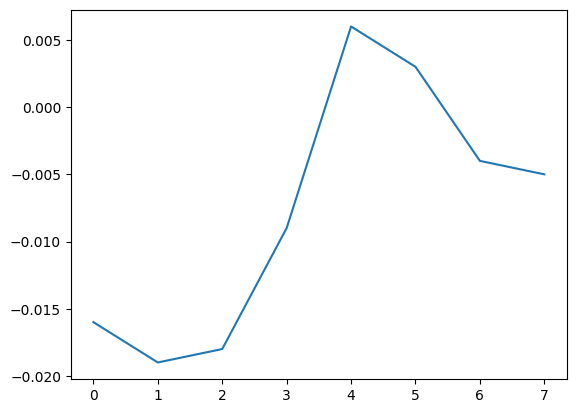

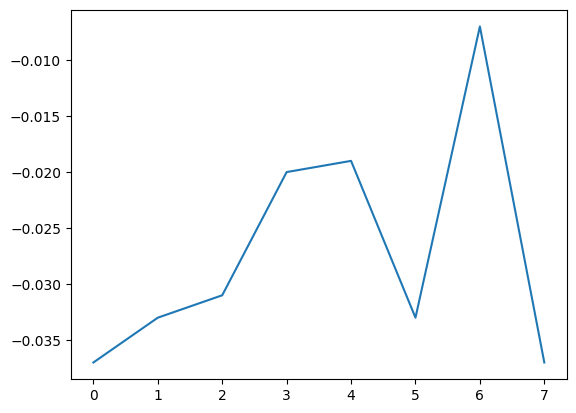

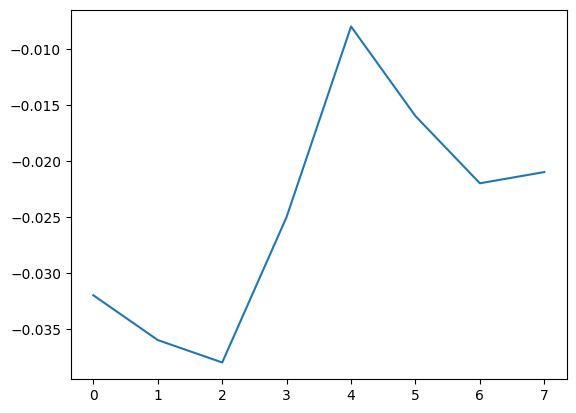

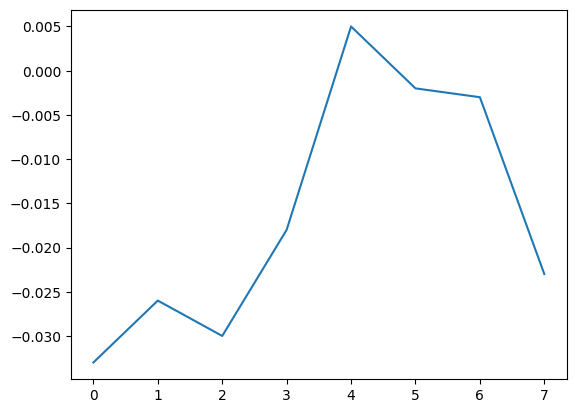

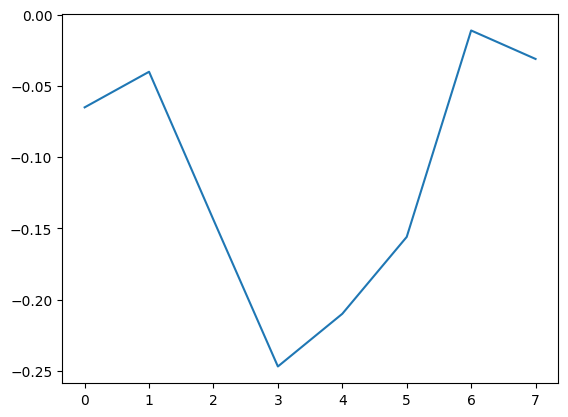

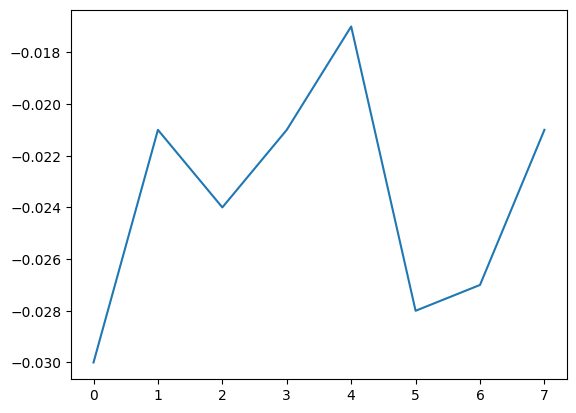

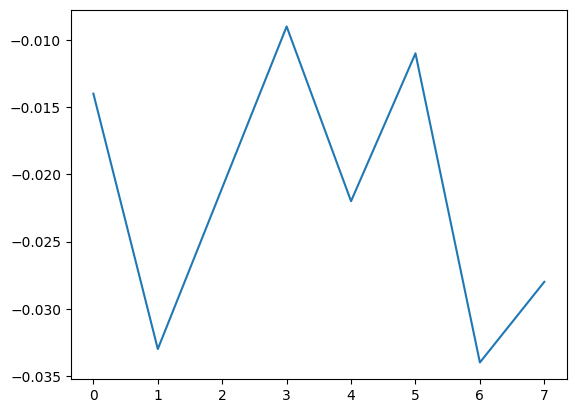

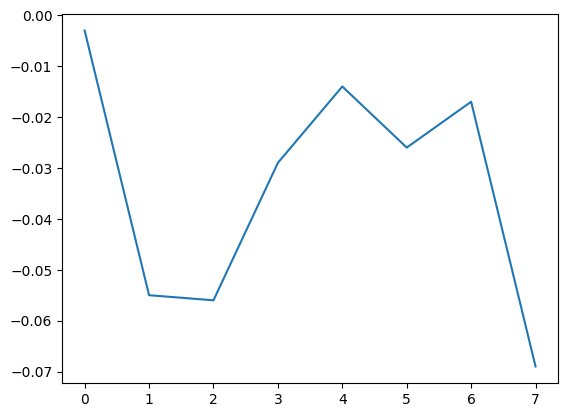

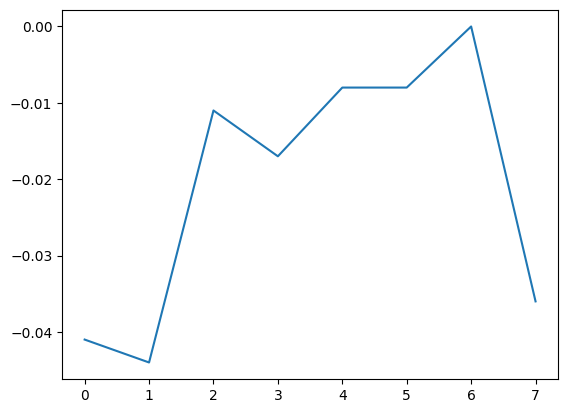

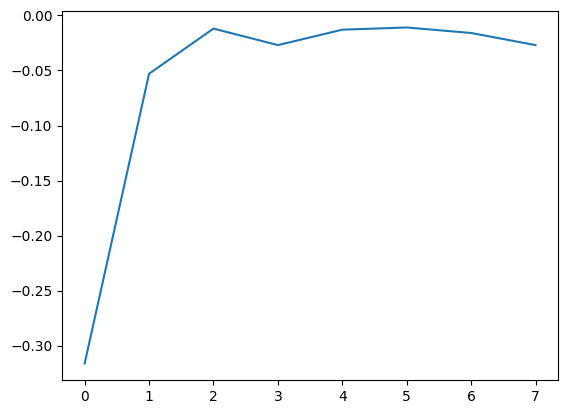

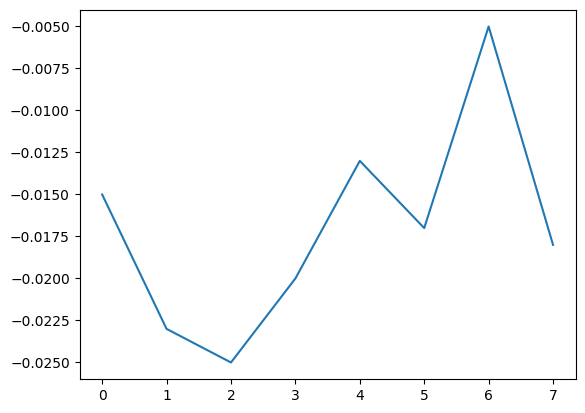

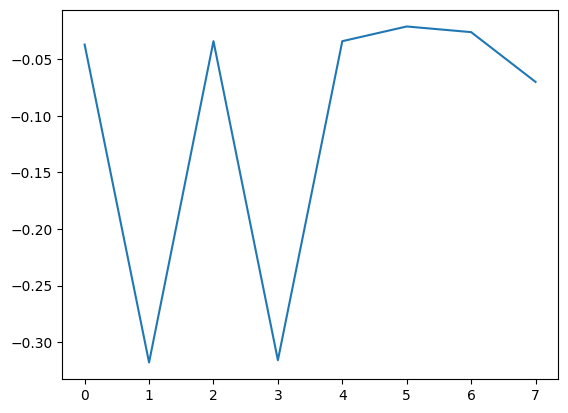

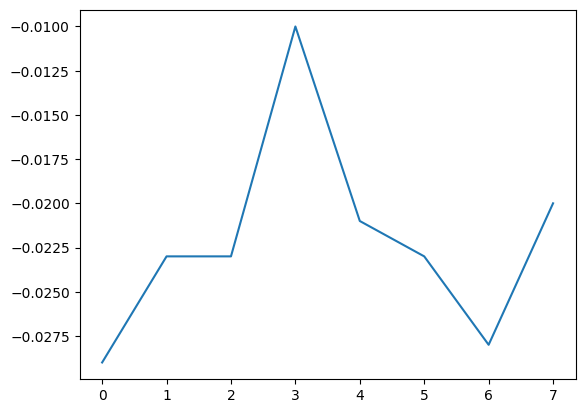

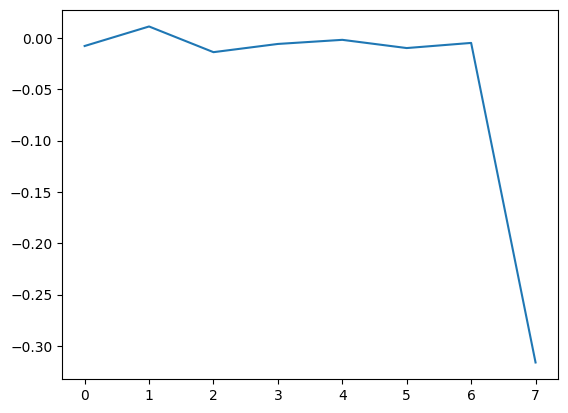

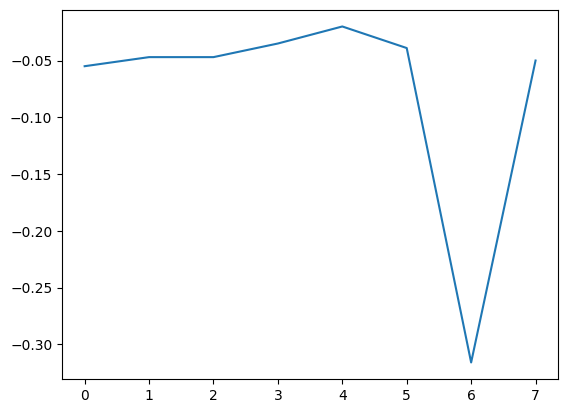

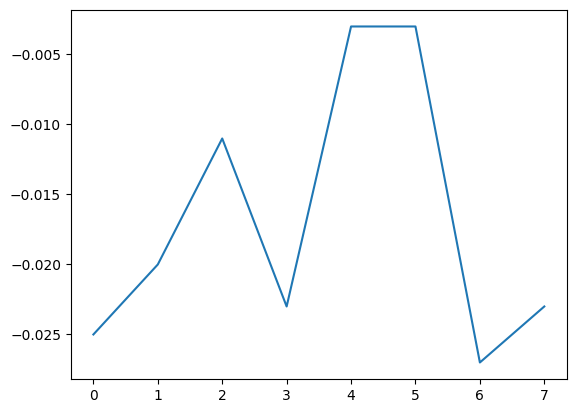

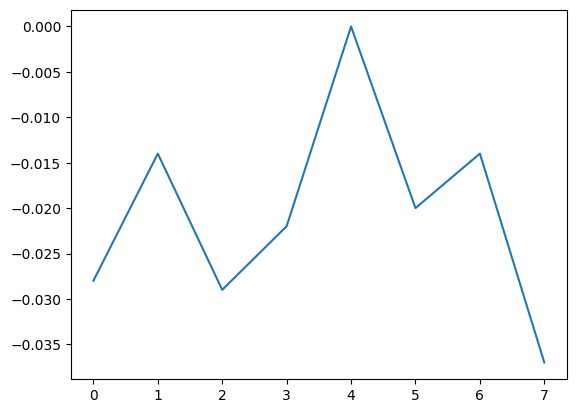

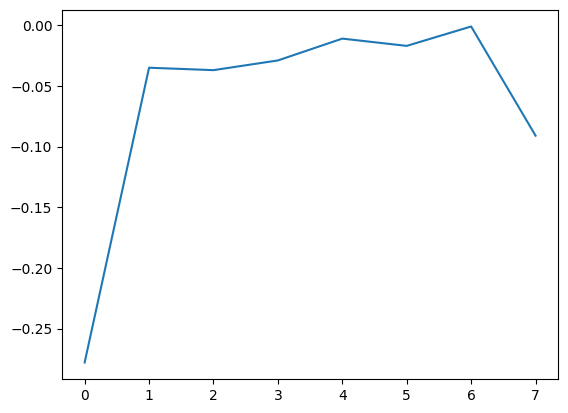

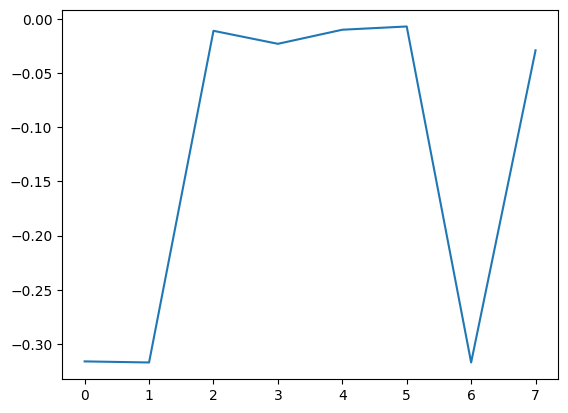

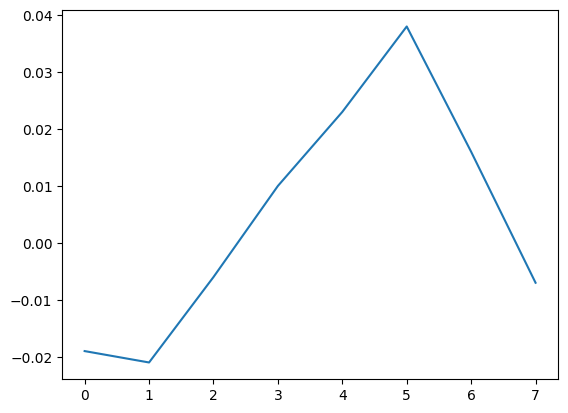

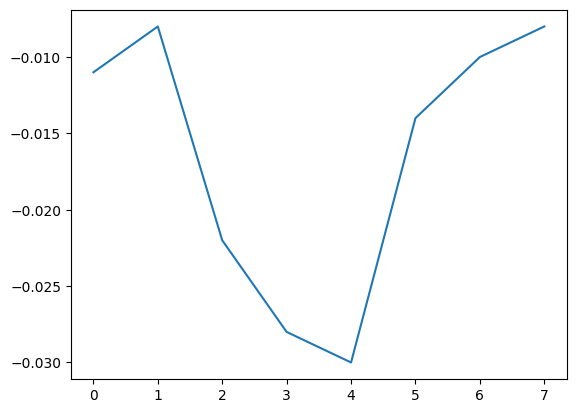

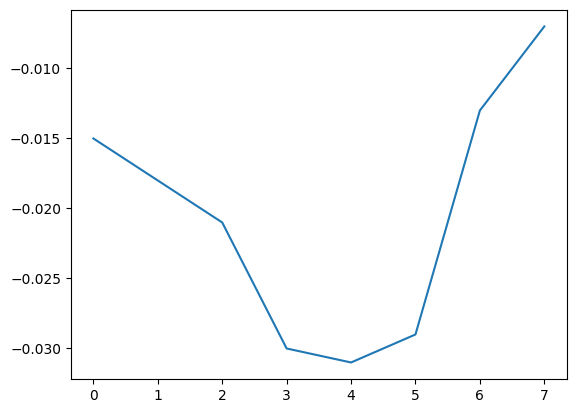

In [10]:
for a in range(len(onset_delay)):
    plt.figure
    plt.plot(onset_delay[a])
    plt.show()

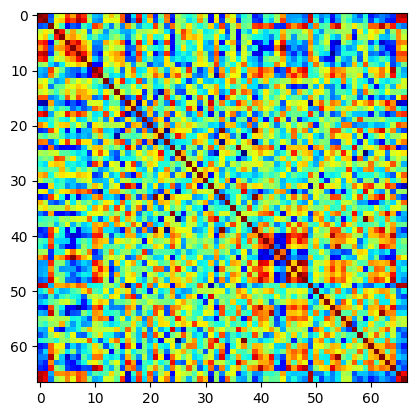

In [19]:
p = np.corrcoef(onset_delay)-1

plt.imshow(p, aspect='equal', cmap='jet', origin='upper') 
plt.savefig('distMat.jpg', dpi=300)

In [21]:
embedding = MDS(dissimilarity='euclidean', random_state = 1)
p_t = embedding.fit_transform(p)

/home/jb/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


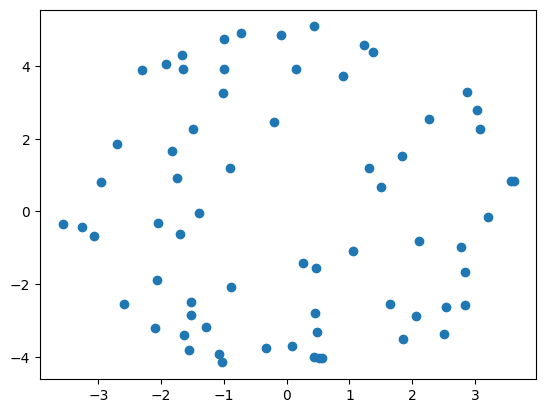

In [22]:
plt.scatter(p_t.T[0], p_t.T[1])

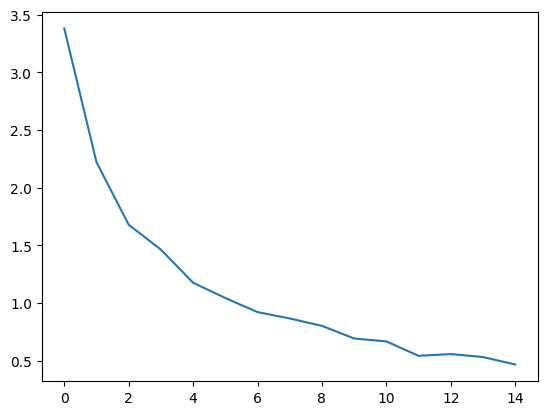

In [23]:
# GMM analysis for categorization

from sklearn import mixture

total_rmse = []
total_g_idx = []
for comp_num in range(15):
    g = mixture.GaussianMixture(n_components = comp_num + 1, covariance_type = 'spherical')
    g.fit(p_t)
    idx = g.predict(p_t)
    
    g_idx = []
    rmse = []
    for a in range(comp_num + 1):
        temp = idx == a
        temp2 = np.where(temp)
        g_idx.append(temp2[0])
    
        # Calculate RMSE
        
        x_data = p_t[temp2[0], [0]]; y_data = p_t[temp2[0], [1]]
        
        Ex = np.mean(x_data); Ey = np.mean(y_data);
        E_xy=[Ex, Ey]
        e_dist = np.sqrt((x_data - E_xy[0]) ** 2 + (y_data - E_xy[1]) ** 2)
        rmse.append(np.mean(e_dist))
        
    rmse_mean = np.mean(rmse)
    total_rmse.append(rmse_mean)
    
    g_idx = np.array(g_idx, dtype = object)
    total_g_idx.append(g_idx)

plt.plot(total_rmse)

In [24]:
idx = total_g_idx[4]

In [25]:
idx

array([array([ 3, 12, 20, 22, 25, 26, 35, 38, 52, 55, 56]),
       array([ 5,  6,  7,  8, 23, 44]),
       array([ 2, 10, 11, 16, 17, 21, 24, 27, 31, 33, 36, 39, 40, 41, 42, 45, 46,
              47, 48, 50, 51, 53, 54, 57, 58, 60, 61, 62, 63, 64])               ,
       array([ 9, 13, 14, 19, 28, 30, 32, 37, 43, 59]),
       array([ 0,  1,  4, 15, 18, 29, 34, 49, 65, 66])], dtype=object)

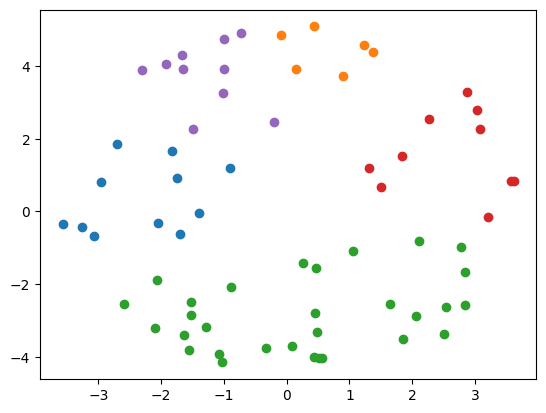

In [26]:
# Plotting

for a in range(len(idx)):
    plt.scatter(p_t[idx[a],[0]], p_t[idx[a],[1]])
# for a in [3,4]:
#     plt.scatter(p_t[idx[a],[0]], p_t[idx[a],[1]],5,'r')

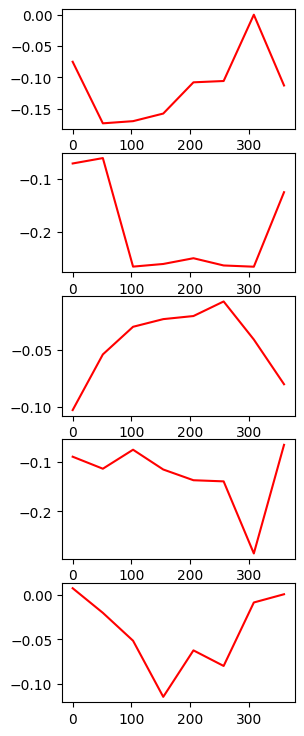

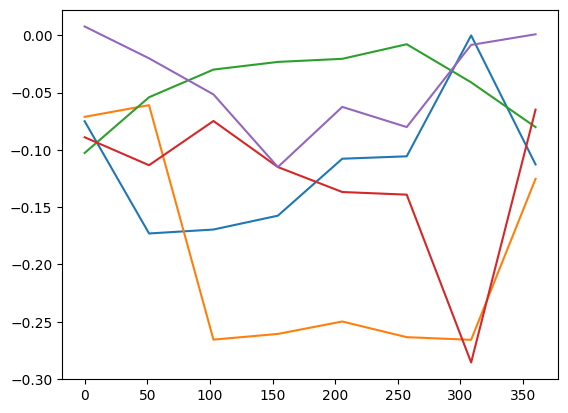

In [27]:
# Mean latency patterns in each cluster
_, axs = plt.subplots(nrows=5, figsize=(3,9))

onset_delay_by_C = []
for a in range(len(idx)):
#    ax = plt.subplot(5, 1, a + 1)
    m_d = np.mean(onset_delay[idx[a], :], axis = 0)
    onset_delay_by_C.append(m_d)
    # axs[a].plot(np.linspace(0, 360, 8), onset_delay_no_mean[idx[a],:].T, 'k', alpha=0.3)    
    axs[a].plot(np.linspace(0, 360, 8), m_d, 'r')

plt.figure()
for a in range(len(idx)):
    m_d = np.mean(onset_delay[idx[a], :], axis = 0)
    plt.plot(np.linspace(0, 360, 8), m_d)

In [28]:
ori_list = [2, 1, 0, 7, 6, 5, 4, 3]
for a in ori_list:
    plt.figure()
    plt.plot(np.sin(x[0+a:8+a]))

NameError: name 'x' is not defined

<Figure size 640x480 with 0 Axes>

/home/jb/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/tmp/ipykernel_15313/343163778.py:38: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(p_t2.T[0, 0+a*8:8+a*8], p_t2.T[1, 0+a*8:8+a*8], c=np.array([0, 0, 0])+a/9)


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

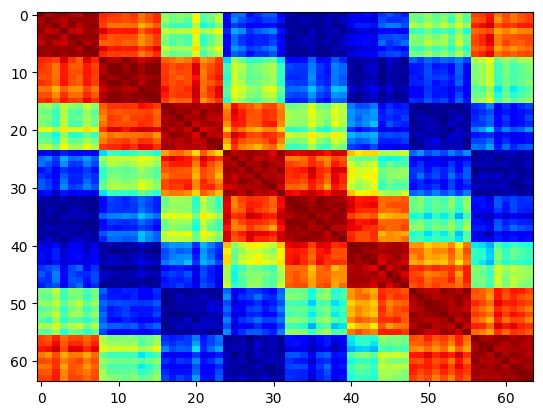

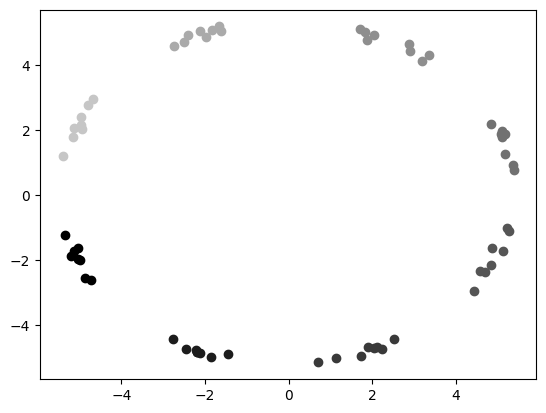

In [29]:
# MDS space from sin and cos 

import random

ori_list = [2, 1, 0, 7, 6, 5, 4, 3]

x = np.linspace(0, 4 * np.pi, 16, endpoint=False)
ratio = 0.7

sin_total = []
sin_intact = []
# for a in range(8):
for a in ori_list:
    plt.figure()
    signal = np.sin(x[0+a:8+a])

    sin_intact.append(signal)

    noise_list = []
    for a in range(8):
        nl = random.choices(np.linspace(0, 1, 8), k=8)
        noise_list.append(nl)
    noise_list = np.array(noise_list)

    signal_nl = signal + (noise_list * ratio)
    sin_total.append(signal_nl)

sin_total = np.concatenate(sin_total)
sin_intact = np.array(sin_intact)

p = np.corrcoef(sin_total)-1
plt.imshow(p, aspect='auto', cmap='jet', origin='upper')     

embedding = MDS(dissimilarity='euclidean', random_state = 1)
p_t2 = embedding.fit_transform(p)
plt.figure()
for a in range(8):
    plt.scatter(p_t2.T[0, 0+a*8:8+a*8], p_t2.T[1, 0+a*8:8+a*8], c=np.array([0, 0, 0])+a/9)

In [30]:
sin_intact

final = []
for a in range(8):
    tt = np.corrcoef(sin_intact[a], onset_delay)[0][1:]
    final.append(tt)
final = np.array(final)

In [31]:
idx_fit = []
for a in range(8):
    value = sorted(final[a], reverse=True)
    index = sorted(range(len(final[a])), key=lambda k: final[a][k],reverse=True)

    idx_fit.append(index[:5])

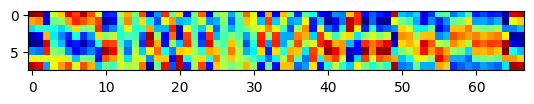

In [32]:
plt.imshow(final, cmap='jet')

/tmp/ipykernel_15313/961690363.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(p_t[idx_fit[a],[0]], p_t[idx_fit[a],[1]], c = np.array([0, 0, 0])+a/10)
/tmp/ipykernel_15313/961690363.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(p_t2_rotated.T[0, 0+a*8:8+a*8], -p_t2_rotated.T[1, 0+a*8:8+a*8], 5, c=np.array([0, 0, 0])+a/9)
/tmp/ipykernel_15313/961690363.py:33: UserWarning: *c* argument looks 

(np.float64(-6.01900182110332),
 np.float64(5.864795740647145),
 np.float64(-5.853053856496945),
 np.float64(6.081403131566545))

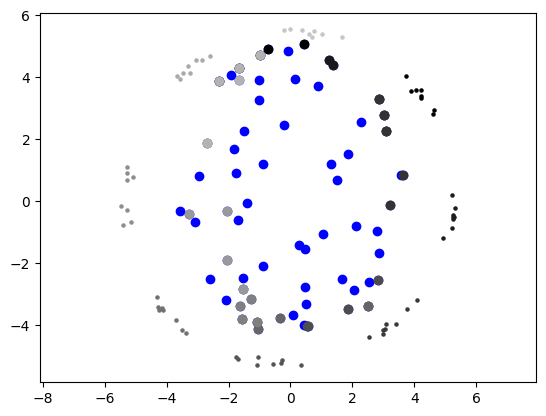

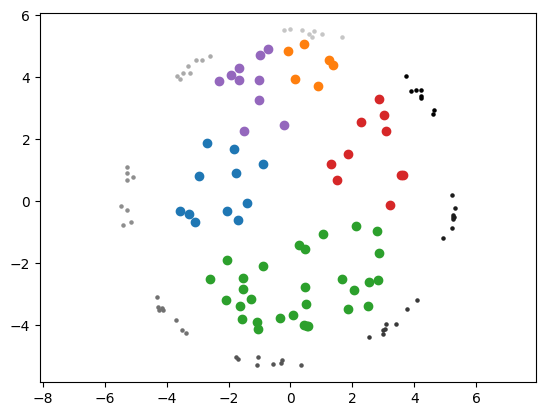

In [33]:
for a in range(len(idx)):
    plt.scatter(p_t[idx[a],[0]], p_t[idx[a],[1]], c = 'b')

for a in range(8):
    plt.scatter(p_t[idx_fit[a],[0]], p_t[idx_fit[a],[1]], c = np.array([0, 0, 0])+a/10)

# rotate matrix
theta = np.radians(-120)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

# Rotate the points
p_t2_rotated = p_t2 @ R

for a in range(8):
    plt.scatter(p_t2_rotated.T[0, 0+a*8:8+a*8], -p_t2_rotated.T[1, 0+a*8:8+a*8], 5, c=np.array([0, 0, 0])+a/9)    

plt.axis('equal')

plt.figure()
for a in range(len(idx)):
    plt.scatter(p_t[idx[a],[0]], p_t[idx[a],[1]])

# rotate matrix
theta = np.radians(-120)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])

# Rotate the points
p_t2_rotated = p_t2 @ R

for a in range(8):
    plt.scatter(p_t2_rotated.T[0, 0+a*8:8+a*8], -p_t2_rotated.T[1, 0+a*8:8+a*8], 5, c=np.array([0, 0, 0])+a/9)    

plt.axis('equal')

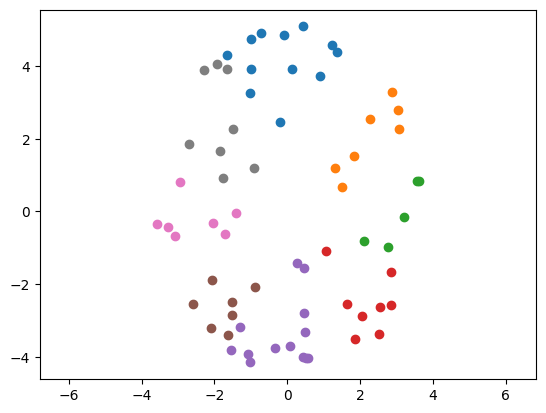

In [34]:
#Sorting cell by degree

from scipy.spatial import distance
from math import degrees

sp1 = np.argsort(p_t[:,1])[::-1][:5]
sp2 = np.argsort(np.abs(p_t[sp1, :][:, 0]))
sp = sp1[sp2[0]]

# p = p_t[sp]
cent = np.mean(p_t, axis=0)
p = [cent[0], cent[1] + 6]

deg_f = []
for a in range(len(p_t)):
    q = p_t[a]
    cos = 1-distance.cosine(p, q)
    deg = degrees(np.arccos(cos))
    if q[0] - p[0] < 0:
        deg = 360 - deg

    deg_f.append(deg)
deg_f = np.array(deg_f)

deg_idx = np.linspace(0, 360, 9) + 22.5
deg_idx = np.append(deg_idx[7], deg_idx[:7])

C_cat = []
for a in range(len(deg_idx)):
    if a == 0:
        C = np.where(np.logical_or(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    elif a == 7:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[0]))
    else:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    C_cat.append(C)

# plotting
for a in range(8):
    plt.scatter(p_t[[C_cat[a]],0], p_t[[C_cat[a]],1])
plt.axis('equal')

plt.savefig('mdsSpace.jpg', dpi=300)

In [133]:
x = np.linspace(0, 4 * np.pi, 16, endpoint=False)

sin_total = []
for a in range(8):
    plt.figure()
    signal = np.sin(x[0+a:8+a])

    sin_total.append(signal)

sin_total = np.array(sin_total)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [145]:
#

r_total = []
for a in range(len(onset_delay)):

    r_coeff = np.corrcoef(onset_delay[a], sin_total)[0][1:]
    r_total.append(r_coeff)

r_total = np.array(r_total)

In [158]:
I_total = []
for a in range(8):
    I = np.where(max(r_total[:, a]) == r_total[:, a])
    I_total.append(I[0][0])

I_total = np.array(I_total)

In [160]:
I_total

array([43, 43,  0, 49, 20, 45, 64, 16])

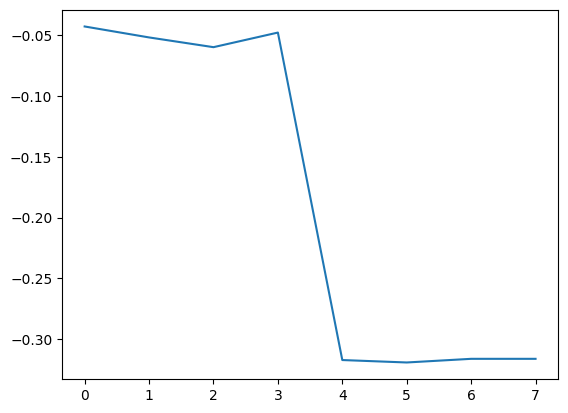

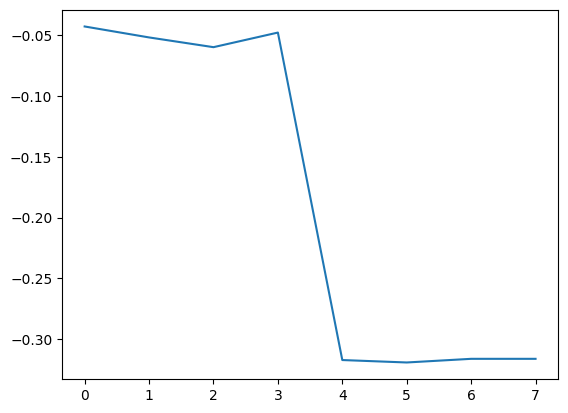

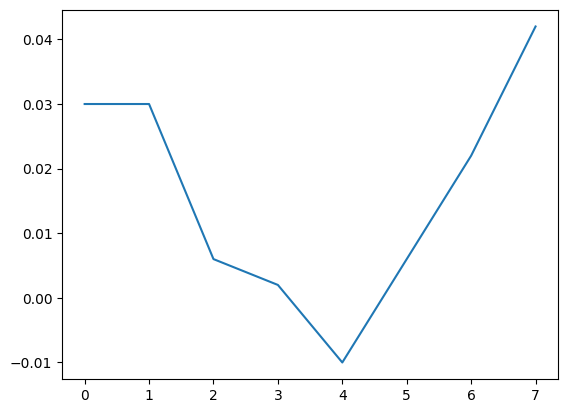

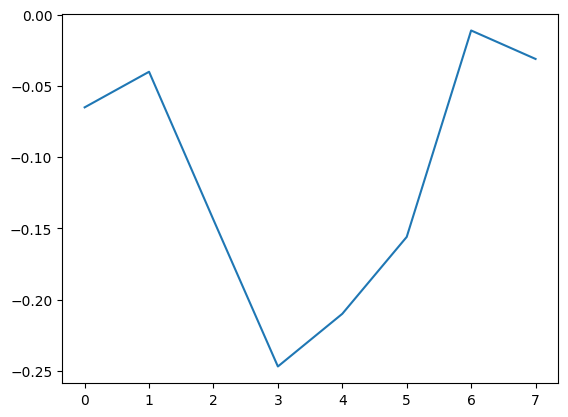

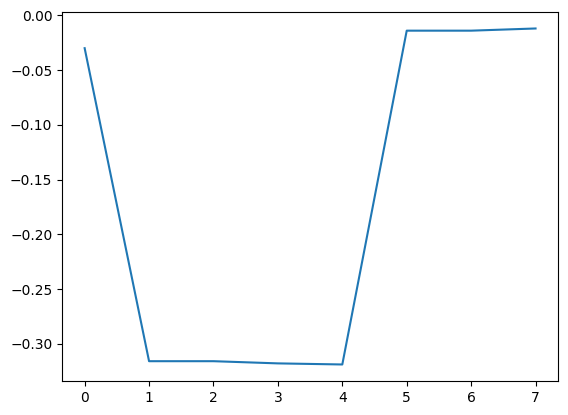

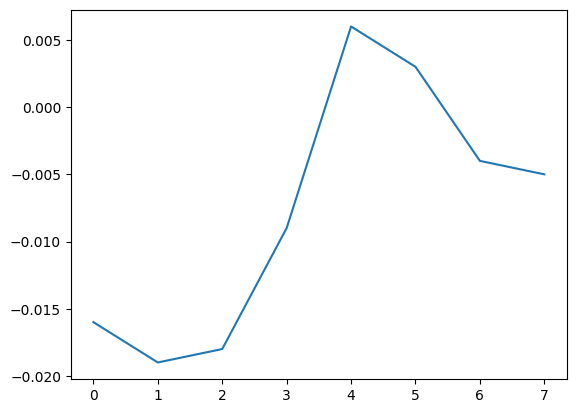

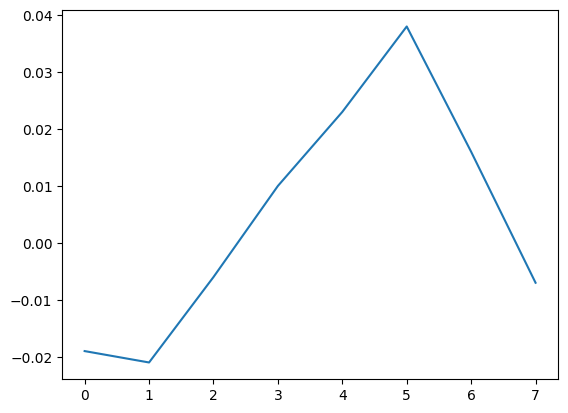

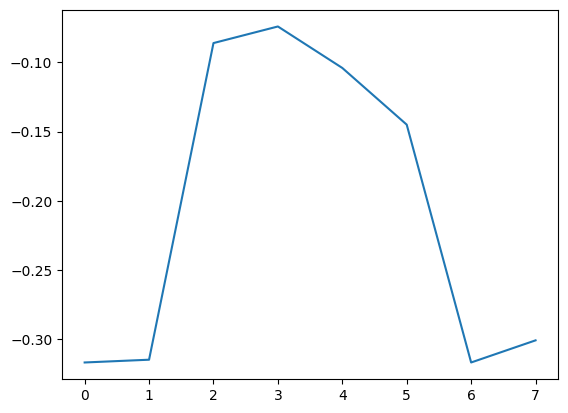

In [163]:
for a in I_total:
    plt.figure()
    plt.plot(onset_delay[a])

In [148]:
np.vstack(r_total)

array([[-0.2927664 ,  0.4391496 ,  0.91381771,  0.85318381,  0.2927664 ,
        -0.4391496 , -0.91381771, -0.85318381],
       [-0.20188186,  0.48938566,  0.8939777 ,  0.77488973,  0.20188186,
        -0.48938566, -0.8939777 , -0.77488973],
       [-0.2154357 , -0.713081  , -0.79301312, -0.40840891,  0.2154357 ,
         0.713081  ,  0.79301312,  0.40840891],
       [-0.21961191, -0.03832136,  0.16541732,  0.27225678,  0.21961191,
         0.03832136, -0.16541732, -0.27225678],
       [-0.29710516,  0.04128205,  0.3554868 ,  0.4614522 ,  0.29710516,
        -0.04128205, -0.3554868 , -0.4614522 ],
       [-0.12787811,  0.45831758,  0.77603705,  0.63916454,  0.12787811,
        -0.45831758, -0.77603705, -0.63916454],
       [ 0.33849165,  0.70672331,  0.66096604,  0.22802382, -0.33849165,
        -0.70672331, -0.66096604, -0.22802382],
       [-0.01324626,  0.6072017 ,  0.87195913,  0.62593473,  0.01324626,
        -0.6072017 , -0.87195913, -0.62593473],
       [ 0.04115015,  0.46781374

In [ ]:
#

I_total = []
M_total = []
for a in range(len(onset_delay)):

    r_coeff = np.corrcoef(onset_delay[a], sin_total)[0][1:]
    M = max(r_coeff)
    I = np.where(M == r_coeff)[0][0]
    M_total.append(M)
    I_total.append(I)

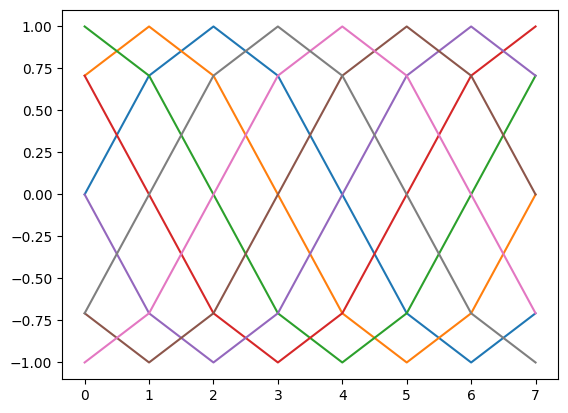

In [134]:
for a in range(8):
    plt.plot(sin_total[a])

In [135]:
np.corrcoef(onset_delay[0], sin_total)[0][1:]

array([-0.2927664 ,  0.4391496 ,  0.91381771,  0.85318381,  0.2927664 ,
       -0.4391496 , -0.91381771, -0.85318381])

In [33]:
# Distance matrix by cross correlation

from scipy import signal

f = 1  # frequency

lags_total = []
for a in range(len(onset_delay)):

    ori = np.shape(onset_delay)[1]
    lags = signal.correlation_lags(len(signal1), len(signal2))

    lags_totalp = []
    for b in range(len(onset_delay)):
    
        signal1 = onset_delay[a]
        signal2 = onset_delay[b]
    
        # Calculate cross-correlation
        cross_correlation = signal.correlate(signal1, signal2)
        
        m_idx = np.argmax(cross_correlation)
        lags_totalp.append(lags[m_idx])

    lags_total.append(lags_totalp)
    
lags_total = np.array(lags_total)

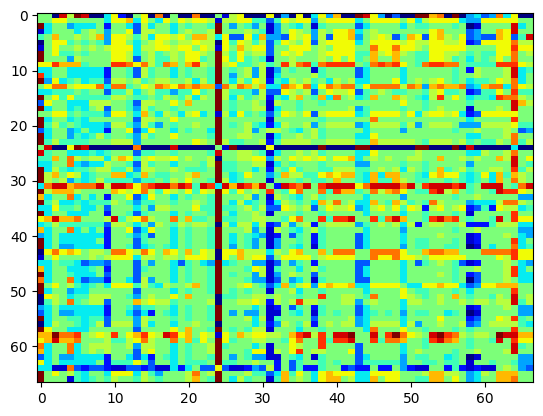

In [40]:
plt.imshow(lags_total, aspect='auto', cmap='jet', origin='upper') 

In [45]:
embedding = MDS(dissimilarity='euclidean', random_state = 1)
p_t = embedding.fit_transform(lags_total)

C:\Users\IBS\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


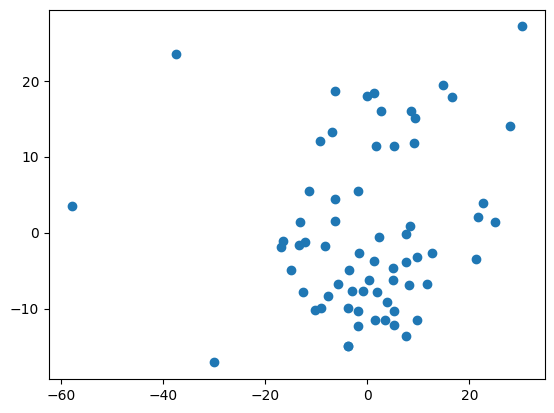

In [46]:
plt.scatter(p_t.T[0], p_t.T[1])

In [27]:
# Distance matrix by cross correlation (sin)

from scipy import signal

lags_total_sin = []
lags_total_cos = []
for a in range(len(onset_delay)):
    f = 1  # frequency
    
    signal1 = onset_delay[a]; ori = len(signal1)
    signal2 = np.sin(f * 2 * np.pi * np.linspace(0, ori, ori))
    signal3 = np.cos(f * 2 * np.pi * np.linspace(0, ori, ori))
    
    # Calculate cross-correlation
    cross_correlation = signal.correlate(signal1, signal2)
    cross_correlation2 = signal.correlate(signal1, signal3)
    lags = signal.correlation_lags(len(signal1), len(signal2))

    m_idx = np.argmax(cross_correlation)
    m_idx2 = np.argmax(cross_correlation2)
    lags_total_sin.append(lags[m_idx])
    lags_total_cos.append(lags[m_idx2])
    
lags_total_sin = np.array(lags_total_sin)
lags_total_cos = np.array(lags_total_cos)

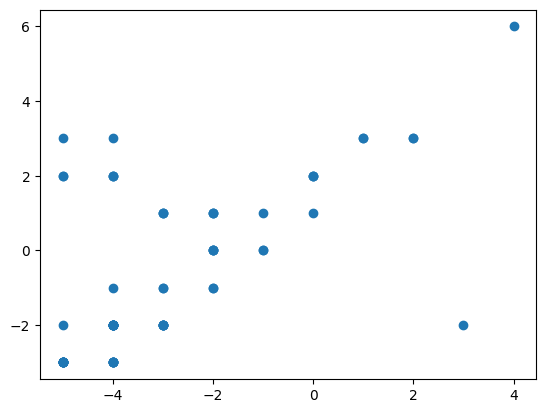

In [30]:
plt.scatter(lags_total_sin, lags_total_cos)

In [ ]:
# Sorting cells depending on lag

lags_total_cat = []
c_num = []
for a in lags:
    idx_temp = np.where(lags_total == a)
    lags_total_cat.append(idx_temp[0])

    c_num.append(len(idx_temp[0]))

lags_total_cat = np.array(lags_total_cat, dtype = object)

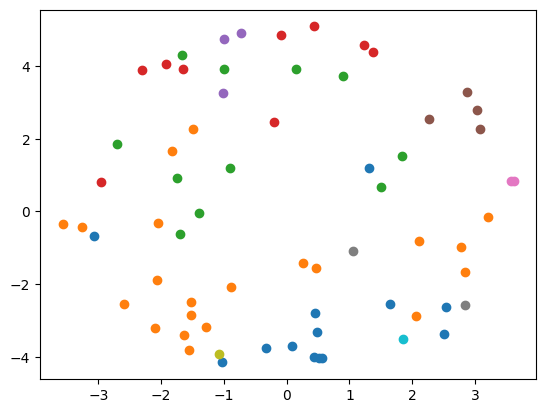

In [20]:
# Plotting

idx = lags_total_cat[np.where(c_num)]

for a in range(len(idx)):
    plt.scatter(p_t[idx[a],[0]], p_t[idx[a],[1]])

In [ ]:
# Distance matrix by cross correlation

from scipy import signal

lags_total=[]
for a in range(len(onset_delay)):
    f = 1  # frequency
    
    signal1 = onset_delay[a]; ori = len(signal1)
    signal2 = np.sin(f * 2 * np.pi * np.linspace(0, ori, ori))
    
    # Calculate cross-correlation
    cross_correlation = signal.correlate(signal1, signal2)
    lags = signal.correlation_lags(len(signal1), len(signal2))

    m_idx = np.argmax(cross_correlation)
    lags_total.append(lags[m_idx])
    
lags_total = np.array(lags_total)
    
# Sorting cells depending on lag

lags_total_cat = []
c_num = []
for a in lags:
    idx_temp = np.where(lags_total == a)
    lags_total_cat.append(idx_temp[0])

    c_num.append(len(idx_temp[0]))

lags_total_cat = np.array(lags_total_cat, dtype = object)